# Data Science and Machine Learning Capstone Project
<div style="text-align: right">
 Dan Thompson         </br> 
 danlthom@us.ibm.com  </br>
 August, 2019         </br>
</div>

## Project 1 - Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#pip install pandas-profiling 

In [4]:
df = pd.read_pickle('./files/df_311.pkl')

In [5]:
df['complaint_type'].value_counts()[:10]

HEAT/HOT WATER          1149530
HEATING                  887869
PLUMBING                 701695
GENERAL CONSTRUCTION     500863
UNSANITARY CONDITION     433927
PAINT - PLASTER          361258
PAINT/PLASTER            340500
ELECTRIC                 302890
NONCONST                 260890
DOOR/WINDOW              199188
Name: complaint_type, dtype: int64

# Clearly Heating and Heat/Hot Water are the top categories
 - But, they are related, so let's combine them...

## Combine Heating with Heat/Hot Water
 - Also, there are two categories of Paint/Plaster
 - And there are several categories that are repeated in uppercase and lowercase, so we'll combine them



In [10]:
# Combine Heat problems
# Combine Paint/Plaster
# Combine uppercase/lowercase spellings

df.loc[df['complaint_type'] == "HEATING",['complaint_type']]="HEAT/HOT WATER"
df.loc[df['complaint_type'] == "PAINT - PLASTER",['complaint_type']]="PAINT/PLASTER"
df['complaint_type'] = df['complaint_type'].str.upper()

df['complaint_type'].value_counts()[:10]

HEAT/HOT WATER          2037399
PAINT/PLASTER            701758
PLUMBING                 701706
GENERAL CONSTRUCTION     500863
UNSANITARY CONDITION     439426
ELECTRIC                 302890
NONCONST                 260890
DOOR/WINDOW              199188
WATER LEAK               186459
GENERAL                  146729
Name: complaint_type, dtype: int64

# Now the combined Heat/Hot Water Complaints are at the top of the list
## Let's show a Bar Chart of all of the categories


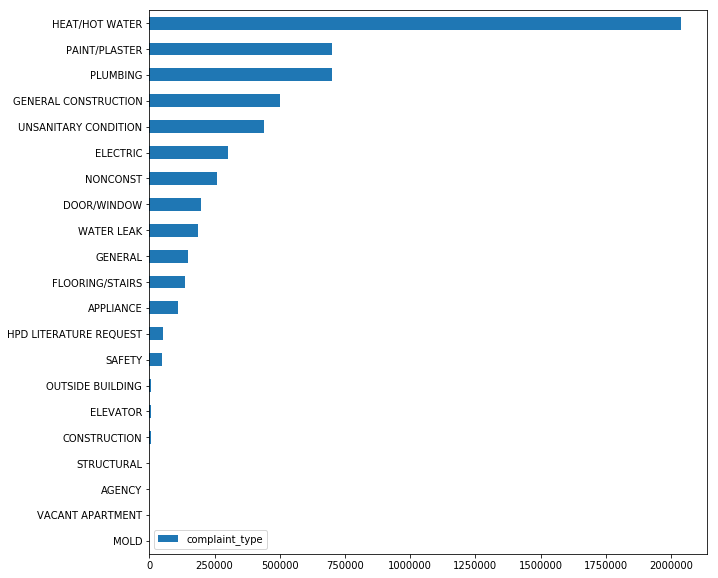

In [7]:
#
# Plot (BARH) all of the complaint types
#

df_complaints = pd.DataFrame(df['complaint_type'].value_counts())
df_complaints.plot(kind="barh", figsize=(10,10))
plt.gca().invert_yaxis()


The bar chart shows the number heating complaints is almost 3 times greater than the next two closest complaint caegories. 

# Further Investigation
 - Let's break this down by year.
 - Even better, let's develop some folds, each of which is a year long!
 - We can use folds to validate our models in later assignements
 - Folds are better than random sampling for timebased data such as these complaint calls
 - A fold is set of 365 days
 - Given that the current year ends on August 16th, let's use that as the end of a fold
 - Then we'll make a list of the top values and narrow the DataFrame to just the top 10

In [8]:
#
#  Create Folds
#

df['DayOfYear'] = df['created_date'].dt.dayofyear
df['Year'] = df['created_date'].dt.year
d = (365-229)                        # August 16th is the 229th day of this year. So let's wrap the folds into the previous year.
m = df['Year'].min()                 # First year of the dataset, most of which we'll throw away
df['SEQ'] = (df['DayOfYear']+d)%365  # The first day of our fold
df['Fold'] = df['Year']            # The fold number 
df.loc[df['SEQ'] <= d,['Fold']]=df['Year']+1 # The fold number for days between Aug 19 and Dec 31#
#df.Fold.astype(str)
df = df[df['Fold'] > 0]             # We can throw out fold zero because it is incomplete

In [9]:
#
# This part is not important. It's just an exercise in displaying the top 10 list
#

top_values = pd.DataFrame(df['complaint_type'].value_counts()[:10]).reset_index()['index']

df = df[df['complaint_type'].isin(top_values.tolist())]

In [11]:
print ("Top 10 List")
print (top_values)

Top 10 List
0          HEAT/HOT WATER
1           PAINT/PLASTER
2                PLUMBING
3    GENERAL CONSTRUCTION
4    UNSANITARY CONDITION
5                ELECTRIC
6                NONCONST
7             DOOR/WINDOW
8              WATER LEAK
9                 GENERAL
Name: index, dtype: object


In [12]:
#
# Prepare to plot the top 10 by Fold / Year
#

df_x = df[(df['Fold'] > 0) & (df['complaint_type'].isin(top_values))] 
df_d = pd.get_dummies(df_x['complaint_type'])
df_d = df_x.join(df_d, how="left")
df_d.head()
df_d = df_d.groupby(by=['Fold']).sum()[top_values]
df_d.head()

,HEAT/HOT WATER,PAINT/PLASTER,PLUMBING,GENERAL CONSTRUCTION,UNSANITARY CONDITION,ELECTRIC,NONCONST,DOOR/WINDOW,WATER LEAK,GENERAL
Fold,,,,,,,,,,
2010,102727.0,58599.0,69861.0,78208.0,0.0,24158.0,40487.0,0.0,0.0,0.0
2011,218578.0,91330.0,107145.0,126769.0,0.0,38051.0,70634.0,0.0,0.0,0.0
2012,180794.0,93195.0,102881.0,125886.0,0.0,36028.0,64395.0,0.0,0.0,0.0
2013,201767.0,79153.0,88528.0,115658.0,0.0,36753.0,56139.0,0.0,0.0,8.0
2014,222469.0,78123.0,74126.0,54342.0,31634.0,32126.0,29235.0,14968.0,16242.0,19017.0


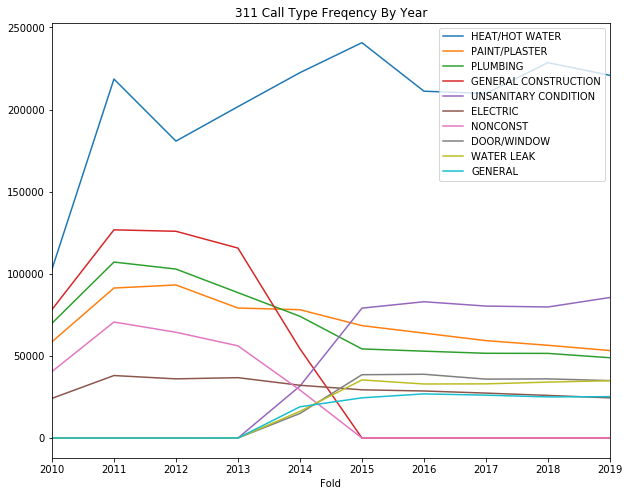

In [11]:
df_d.plot(figsize=(10,8), title="311 Call Type Freqency By Year" )


# Top 10 complaints for folds 2011 through 2019

## Big Insight! Clearly something changed around 2014/2015
 - NYC changed the way they collect / count data in 2014/2015, which is our fold #5
 - The data looks stable starting in 2015
 - Therefore we can just use the last 5 folds worth of data
 - It is clear that Heating Problems outpace other problems by a huge amount.

## Let's save the 5 years of heat/hot water complaints to a pickle file

In [12]:
df_hot = df[(df['Fold'] > 2014) & (df['complaint_type'] == "HEAT/HOT WATER")] 
df_hot.head()

,created_date,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,location_type,status,DayOfYear,Year,SEQ,Fold
unique_key,,,,,,,,,,,,,,,,,
43568281,2019-08-16 07:50:14,HEAT/HOT WATER,11216,751 ST MARKS AVENUE,ST MARKS AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.675098,-73.947870,RESIDENTIAL BUILDING,Open,228,2019,364,2019
43561061,2019-08-16 11:51:14,HEAT/HOT WATER,11224,2843 WEST 25 STREET,WEST 25 STREET,ADDRESS,BROOKLYN,The complaint you filed is a duplicate of a co...,BROOKLYN,40.577074,-73.992419,RESIDENTIAL BUILDING,Open,228,2019,364,2019
43565793,2019-08-16 22:25:58,HEAT/HOT WATER,10452,80 WEST 170 STREET,WEST 170 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.840342,-73.922157,RESIDENTIAL BUILDING,Open,228,2019,364,2019
43567272,2019-08-16 06:07:17,HEAT/HOT WATER,10031,723 ST NICHOLAS AVENUE,ST NICHOLAS AVENUE,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.824803,-73.944212,RESIDENTIAL BUILDING,Open,228,2019,364,2019
43563447,2019-08-16 08:45:38,HEAT/HOT WATER,10461,3108 WILKINSON AVENUE,WILKINSON AVENUE,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.851653,-73.828635,RESIDENTIAL BUILDING,Open,228,2019,364,2019


## Let's save that to a pickle file for the next Assignment

In [13]:
df_hot.to_pickle('./files/df_hot.pkl')

# Conclusions

First off, always look at the data. I found several categories that were repeated, spelled differently, or had name changes. If you don't look at the data you'll never find these errors.

Next, my initial discovery showed that Heating and Heat/Hot Water complaints were the top categories. However, it is clear that these two categories are really the same and must be combined.  

Next, I divided the data into folds, each spanning one year, offset by about 4 months. 

## Major Insights

Plotting the top ten categories shows that NYC changed the way they collect data starting in the 2014/2015  
5 years of data is enough for later analysis.  
Heating problems continue to outpace other problems by a huge amount.

ALWAYS LOOK AT THE DATA BEFORE YOU START WORKING WITH IT! IT COULD BE UGLY!!!

Daniel Thompson  
danlthom@us.ibm.com  
August 2019  
